In [1]:
# default_exp analyses

# Alternative Contiguity Analysis
Are contextual associations revealed during free recall stronger for the original or the secondary (or the tertiary) presentation context of repeatedly studied items?

To find out, perform lag-CRP analysis transformed to:
- Only consider transitions from a repeatedly studied item
- Separately measure using lags from primary and secondary (and tertiary) presentation positions

## Function

In [1]:
from repetition_cmr.analyses import recall_by_all_study_positions

In [2]:
# export

from numba import njit
import numpy as np

@njit(nogil=True)
def repetition_contiguity(trials, presentations, lag_threshold = 3, max_repeats = 2):
    
    list_length = len(presentations[0])
    lag_range = list_length - 1
    total_actual_lags = np.zeros((max_repeats, lag_range * 2 + 1)) # extended dimension to split by pres positions
    total_possible_lags = np.zeros((max_repeats, lag_range * 2 + 1))
    terminus = np.sum(trials != 0, axis=1) # number of recalls per trial
    recall_by_study_position = recall_by_all_study_positions(trials, presentations, max_repeats)
    
    for trial_index in range(len(trials)):
        previous_item = 0
        item_count = np.max(presentations[trial_index]) + 1
        possible_items = np.arange(item_count) # initial pool of possible recalls, 1-indexed
        possible_positions = np.zeros((item_count, max_repeats), dtype=np.int32)
        
        # we track possible positions using presentations and alt_presentations
        for item in range(item_count):
            pos = np.nonzero(presentations[trial_index] == item)[0] + 1
            possible_positions[item, :len(pos)] = pos
            
        for recall_index in range(terminus[trial_index]):

            current_item = presentations[trial_index][trials[trial_index, recall_index]-1]
            
            # track possible and actual lags; 
            # focus only on transitions from items with > 1 study positions
            # and only when those multiple study positions have lag over lag
            if recall_index > 0 and np.count_nonzero(
                possible_positions[previous_item]) > 1 and (
                possible_positions[previous_item][1] - possible_positions[previous_item][0] >= lag_threshold):
                
                # item indices don't help track lags anymore
                # so more complex calculation needed to identify possible lags given previous item
                current_index = np.nonzero(possible_items==current_item)[0]

                index = 0
                for x in range(len(recall_by_study_position)):
                    for y in range(len(recall_by_study_position)):
                        if possible_positions[previous_item, y] > 0:
                        
                            possible_lags = possible_positions[
                                possible_items, x] - possible_positions[previous_item, y]
                            
                            # if tracked position is 0, then we don't actually want to count it in our lags
                            possible_lags[possible_positions[possible_items, x] == 0] = 0
                            
                            # we track actual lag at each iteration
                            actual_lag = possible_lags[current_index] + lag_range
                            total_actual_lags[y][actual_lag] += 1

                            # we track possible lag at each iteration
                            possible_lags += lag_range
                            total_possible_lags[y][possible_lags] += 1
                        
                        index += 1

            # update pool to exclude recalled item (updated to still identify 1-indexed item)
            previous_item = current_item
            possible_items = possible_items[possible_items != previous_item]

                                
    # small correction to avoid nans and commit to excluding multiply-tracked single presentations 
    total_actual_lags[:, lag_range] = 0
    for i in range(max_repeats):
        total_possible_lags[i][total_actual_lags[i]==0] += 1
    
    return total_actual_lags/total_possible_lags

## Lohnas & Kahana (2014) Dataset

<AxesSubplot:xlabel='Lag', ylabel='Recall Rate'>

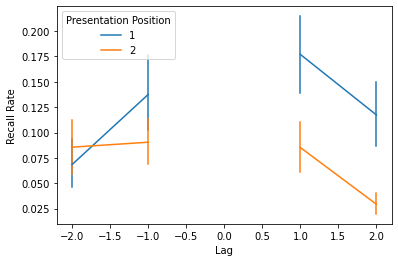

In [3]:
from compmemlearn.datasets import prepare_lohnas2014_data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

lag_range = 39
condition = 4
minimum_lag = 4
repetition_count = 2
max_lag = int(minimum_lag/2)

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

individual_results = []

for subject in np.unique(subjects):
    selection = np.logical_and(list_types == 4, subjects == subject)

    individual_result = repetition_contiguity(
        trials[selection], presentations[selection], minimum_lag, repetition_count)
    individual_result[:, 40-1] = np.nan

    for i in range(repetition_count):
        individual_results.append(pd.DataFrame(
            {'Subject': subject, 'Presentation Position': i+1, 'Lag': np.arange(max_lag*2+1, dtype=int)-max_lag, 'Recall Rate': individual_result[i][list_length-max_lag-1:list_length+max_lag]
            }))

df = pd.concat(individual_results)
filt_neg = f'{-max_lag} <= Lag < 0'
filt_pos = f'0 < Lag <= {max_lag}'
sns.lineplot(x='Lag', y='Recall Rate', hue='Presentation Position', data=df.query(filt_neg), palette='tab10', err_style='bars')
sns.lineplot(x='Lag', y='Recall Rate', hue='Presentation Position', data=df.query(filt_pos), palette='tab10', err_style='bars', legend=False)

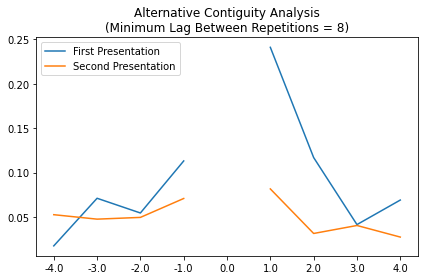

In [4]:
minimum_lag = 8
repetition_count = 2


data_altcrp = repetition_contiguity(
    trials[list_types==condition], presentations[list_types==condition], minimum_lag, repetition_count)
data_altcrp[:, lag_range] = np.nan
plt.plot(np.arange(minimum_lag+1), data_altcrp[0][int(lag_range-(minimum_lag/2)):int(lag_range+(minimum_lag/2)+1)], label='First Presentation')
plt.plot(np.arange(minimum_lag+1), data_altcrp[1][int(lag_range-(minimum_lag/2)):int(lag_range+(minimum_lag/2)+1)], label='Second Presentation')
plt.xticks(np.arange(minimum_lag+1), np.arange(minimum_lag+1) - minimum_lag/2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.legend(['First Presentation', 'Second Presentation'], loc='upper left')
plt.title('Alternative Contiguity Analysis\n(Minimum Lag Between Repetitions = {})'.format(minimum_lag))
plt.tight_layout()

## Howard & Kahana (2005) Dataset

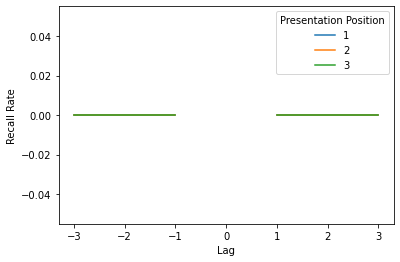

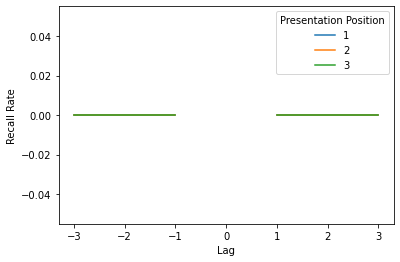

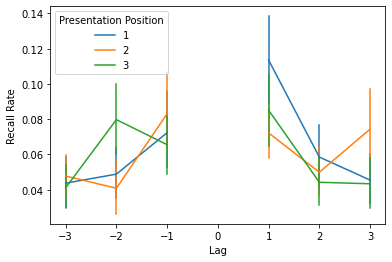

In [5]:
from repetition_cmr.datasets import prepare_howakaha05_data

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_howakaha05_data(
    '../../data/HowaKaha05.dat')

lag_range = list_length-1
minimum_lag = 12
repetition_count = 3
max_lag = int(6/2)

for condition in [0, 2, 1]:

    individual_results = []

    for subject in np.unique(subjects):
        selection = np.logical_and(list_types == condition, subjects == subject)

        individual_result = repetition_contiguity(
            trials[selection], presentations[selection], minimum_lag, repetition_count)
        individual_result[:, list_length-1] = np.nan

        for i in range(3):
            individual_results.append(pd.DataFrame(
                {'Subject': subject, 'Presentation Position': i+1, 'Lag': np.arange(max_lag*2+1, dtype=int)-max_lag, 'Recall Rate': individual_result[i][list_length-max_lag-1:list_length+max_lag]
                }))

    df = pd.concat(individual_results)
    filt_neg = f'{-max_lag} <= Lag < 0'
    filt_pos = f'0 < Lag <= {max_lag}'
    sns.lineplot(x='Lag', y='Recall Rate', hue='Presentation Position', data=df.query(filt_neg), palette='tab10', legend=False, err_style='bars')
    sns.lineplot(x='Lag', y='Recall Rate', hue='Presentation Position', data=df.query(filt_pos), palette='tab10', err_style='bars')
    plt.show()